# Overview

The purposes of this notebook is to create and evaluate models that predict whether or not an ICU patient will develop sepsis. In comparison to the previous Modeling Notebook (4.1), this notebook uses all data points in the pre-sepsis period as target variables, and also calculates classification metrics based on the per patient accuracy of the algorithm rather than just the hour by hour accuracy.
 
 __Methods__
 
    -Test/Train Split
    -Min Max Scaling 
    -Cross Leakage Prevention
    -Hyperparameter Estimation
    -Plotting Feature Importance of Tree-Based Models
    -Model Evaluation ROC Curves, Precision/Recall Curves, Classification Reports & Confusion Matrices
      
 __Results__
 
The most
 

# Code Navigation
* [1. Import Libraries & Data](#1.ImportLibraries&Data)
* [2. Preventing Data Leakage](#2.PreventingDataLeakage)
* [3. Create Test & Train Sets](#3.CreateTest&TrainSets)
* [4. Apply Min/Max Scaler, Ensure CV has No Cross Leakage](#4.ApplyMin/MaxScaler,EnsureCVhasNoCrossLeakage)
* [5. Modeling](#5.Modeling)
    * [5.1. Dummy Classifier](#5.1.DummyClassifier)
    * [5.2. Logistic Regression](#5.2.LogisticRegression)
    * [5.3. Random Forest](#5.3.RandomForest)
    * [5.4. Gradient Boosting](#5.4.GradientBoosting)
        * [5.4.1 First Hyperparameter Search](#5.4.1.FirstHyperparameterSearch)
        * [5.4.1 Second Hyperparameter Search](#5.4.2.SecondHyperparameterSearch)

# 1. Import Libraries & Data <a class="anchor" id="1.ImportLibraries&Data"></a>

In [1]:
#General Imports
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import uniform
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, \
roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc, plot_roc_curve
from sklearn.feature_selection import SelectFromModel

In [3]:
os.chdir("../src/data")
from time_elapsed import time_elapsed
from plotPrecisionRecall_ import Plot_PR
from PlotFeatureImportance import Plot_Feat_Imp
from _patient_Classification_ import PatientLevelClassification
from CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [4]:
os.chdir("../../data/interim")
                                           
os.chdir("../processed")
#Next, the actual data
df=pd.read_csv('sepsis_data_preprocessed.csv',index_col=0)

C:\Users\amcas\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
#Drop Unit/Hospital Identifying Variables
list_=['Unit1','Unit2','HospitalA']
df.drop(columns=list_,inplace=True)

In [6]:
#df_copy=df.copy()
#df=df_copy

# 2. Preventing Data Leakage <a class="anchor" id="2.PreventingDataLeakage"></a>

In [7]:
#Generate matrix with all patient id's randomly shuffled (id_shuff)
np.random.seed(seed=129)
id_shuff=df.id.unique()
np.random.shuffle(id_shuff)
#Split into test & train arrays of 1/4 and 3/4 the original size
n=int(round(id_shuff.size*0.30))
test_id=id_shuff[0:n]
train_id=id_shuff[n:]

In [8]:
#Calculate percent of time points in test df
a=round(len(df[df.id.isin(test_id)])/(len(df))*100,2)
print("The test data set has {}% of the data points".format(a))

The test data set has 29.84% of the data points


In [9]:
#Calculate percent of patients with sepsis in train df 
a=round(df[df.id.isin(train_id)].SepsisOnset.sum()/len(train_id)*100,2)
print("{}% of patients in the train data set have sepsis".format(a))

7.3% of patients in the train data set have sepsis


In [10]:
#Calculate percent of patients with sepsis in test df 
a=round(df[df.id.isin(test_id)].SepsisOnset.sum()/len(test_id)*100,2)
print("{}% of patients in the test data set have sepsis".format(a))

7.19% of patients in the test data set have sepsis


# 3. Create Test & Train Sets <a class="anchor" id="3.CreateTest&TrainSets"></a>

In [11]:
#Create Test/Train X
X_train=df[df.id.isin(train_id)].copy()
X_test=df[df.id.isin(test_id)].copy()

#Split y_train into various classification columns 
y_train_all=X_train['PreSepsisAll']
y_train_six=X_train['PreSepsisSix']

#Split y_test into various classification columns 
y_test_all=X_test['PreSepsisAll']
y_test_six=X_test['PreSepsisSix']

#Drop all classifiers from X
X_train.drop(columns=['SepsisLabel','SepsisOnset','id','PreSepsisSix','PreSepsisAll'],inplace=True)
X_test.drop(columns=['SepsisLabel','SepsisOnset','id','PreSepsisSix','PreSepsisAll'],inplace=True)

#Get Labels for later
Var_names=list(X_train.columns)

# 4. Apply Min/Max Scaler, Ensure CV has No Cross Leakage <a class="anchor" id="4.ApplyMin/MaxScaler,EnsureCVhasNoCrossLeakage"></a>

In [12]:
#Fit Min-Max Scaler to X_train data, transform X_train and X_test data
MM_scale=MinMaxScaler()
MM_scale.fit(X_train)
X_train=MM_scale.transform(X_train)
X_test=MM_scale.transform(X_test)

#Create kfolds CV object (to allow for sequential folding, not random - prevents data leakage in cross folds)
folds=KFold(n_splits=4)

# 5. Modeling <a class="anchor" id="5.Modeling"></a>

## 5.1. Dummy Classifier <a class="anchor" id="5.1.DummyClassifier"></a>

In [13]:
#Model Sepsis Label - Dummy Classifier, Most Frequent
dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy=dummy_clf.fit(X_train, y_train_all).predict(X_test)
print(classification_report(y_test_all,y_pred_dummy,zero_division=0))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    420053
         1.0       0.00      0.00      0.00     43136

    accuracy                           0.91    463189
   macro avg       0.45      0.50      0.48    463189
weighted avg       0.82      0.91      0.86    463189



## 5.2. Logistic Regression <a class="anchor" id="5.2.LogisticRegression"></a>

In [16]:
#Find logsitic regression parameters for modeling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[(1/10)*i for i in range(1,11)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_all)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 34 Minutes 23 Seconds 


{'C': 1.0}

In [17]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_all)

LogisticRegression(max_iter=1000)

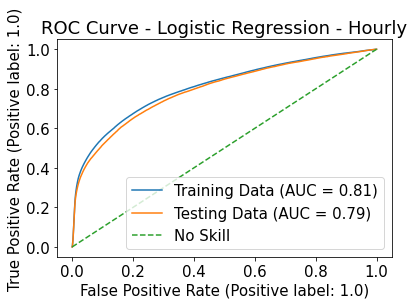

In [716]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf,X_train,y_train_all,ax=_,name='Training Data')
plot_roc_curve(clf,X_test,y_test_all,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression - Hourly')
plt.show()

Best Train Threshold=0.234916, F-Score=0.471
Best Test Threshold=0.232300, F-Score=0.443
Train AUC: 0.431 Test AUC: 0.398


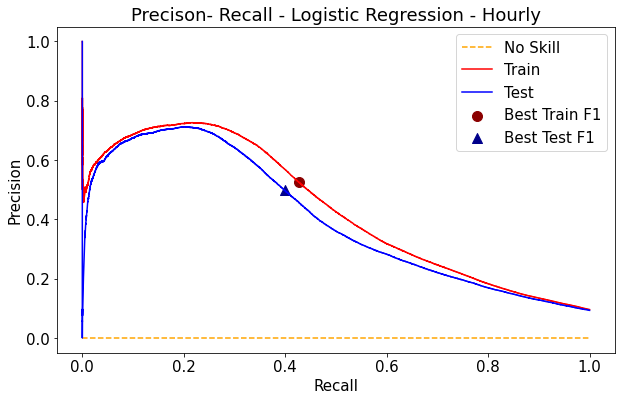

In [717]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logistic Regression - Hourly'
prob=Plot_PR(clf,X_train,y_train_all,X_test,y_test_all,title,auc,precision_recall_curve,np,plt,(10,6))

In [157]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Hourly Data
q=clf.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.234916 else 0 for i in q]
print(classification_report(y_test_all,y_pred_test_new))
print(confusion_matrix(y_test_all,y_pred_test_new))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95    420053
         1.0       0.50      0.40      0.44     43136

    accuracy                           0.91    463189
   macro avg       0.72      0.68      0.70    463189
weighted avg       0.90      0.91      0.90    463189

[[403211  16842]
 [ 26082  17054]]


In [179]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(clf,0.234916,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     11231
           1       0.24      0.34      0.28       870

    accuracy                           0.87     12101
   macro avg       0.59      0.63      0.61     12101
weighted avg       0.90      0.87      0.88     12101

[[10263   968]
 [  571   299]]


## 5.3. Random Forest <a class="anchor" id="5.3.RandomForest"></a>

In [23]:
#Find optimal random forest parameters for modeling Sepsis Label
start = datetime.now()
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [x**2 for x in range(2,5)]
min_samples_split = [4,7,16]
min_samples_leaf = [4,7,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=RandomizedSearchCV(RFC,distributions,random_state=42,n_iter=12,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train_all)
best_dict=search_RFC_Sepsis.best_params_
end = datetime.now()
time_elapsed(start,end)
search_RFC_Sepsis.best_params_

This process took 04 Hours 18 Minutes 16 Seconds 


{'min_samples_split': 4, 'min_samples_leaf': 16, 'max_depth': 16}

In [24]:
#Create Model
RFC=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC.fit(X_train,y_train_all)

RandomForestClassifier(max_depth=16, max_features='sqrt', min_samples_leaf=16,
                       min_samples_split=4, n_estimators=1000, n_jobs=-1,
                       random_state=42)

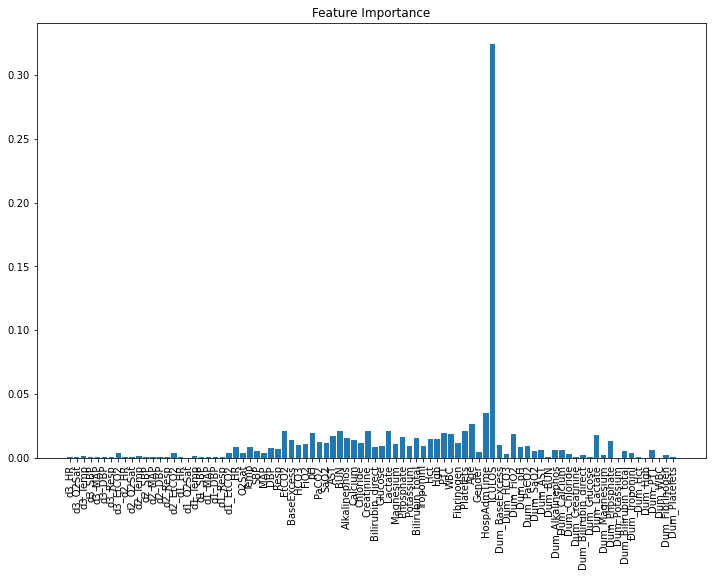

In [25]:
#Plot Feature Importance 
Plot_Feat_Imp(RFC,Var_names,pd,np,plt,(12,8))

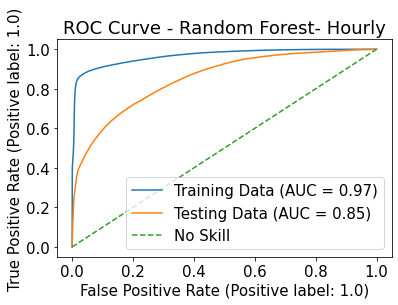

In [718]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(RFC,X_train,y_train_all,ax=_,name='Training Data')
plot_roc_curve(RFC,X_test,y_test_all,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Random Forest- Hourly')
plt.show()

Best Train Threshold=0.187029, F-Score=0.849
Best Test Threshold=0.240358, F-Score=0.495
Train AUC: 0.878 Test AUC: 0.514


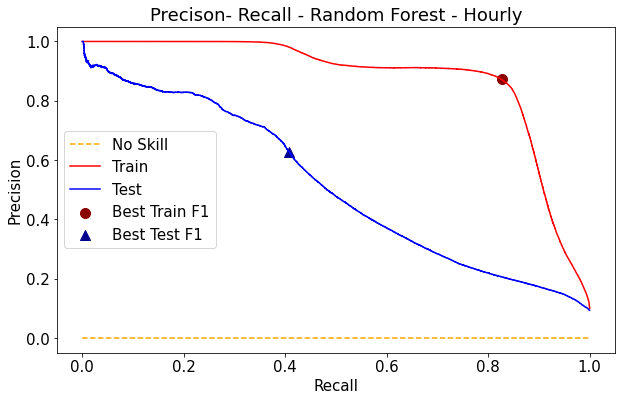

In [715]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Random Forest - Hourly'
prob=Plot_PR(RFC,X_train,y_train_all,X_test,y_test_all,title,auc,precision_recall_curve,np,plt,(10,6))

In [159]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Hourly Data
q=RFC.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.187029 else 0 for i in q]
print(classification_report(y_test_all,y_pred_test_new))
print(confusion_matrix(y_test_all,y_pred_test_new))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    420053
         1.0       0.51      0.47      0.49     43136

    accuracy                           0.91    463189
   macro avg       0.73      0.71      0.72    463189
weighted avg       0.91      0.91      0.91    463189

[[400719  19334]
 [ 22721  20415]]


In [180]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(RFC,0.187029,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     11231
           1       0.26      0.43      0.32       870

    accuracy                           0.87     12101
   macro avg       0.60      0.67      0.62     12101
weighted avg       0.90      0.87      0.88     12101

[[10145  1086]
 [  497   373]]


In [599]:
#CV Testing Results - Assess Hyperparameter performance across CV folds
#Get f1 scores for each fold
a=search_RFC_Sepsis.cv_results_['split0_test_score']
b=search_RFC_Sepsis.cv_results_['split1_test_score']
c=search_RFC_Sepsis.cv_results_['split2_test_score']
d=search_RFC_Sepsis.cv_results_['split3_test_score']
e=np.concatenate((a,b,c,d))
f=search_RFC_Sepsis.cv_results_['mean_test_score']
n=len(search_RFC_Sepsis.cv_results_['params'])
#Get Parameters for each CV
max_depth=[search_RFC_Sepsis.cv_results_['params'][i]['max_depth'] for i in range(n)]
min_samples_split=[search_RFC_Sepsis.cv_results_['params'][i]['min_samples_split'] for i in range(n)]
min_samples_leaf=[search_RFC_Sepsis.cv_results_['params'][i]['min_samples_leaf'] for i in range(n)]
#Tabulate results
print('The  f1 test scores from cross validation had a mean value of {} and a standard deviation of {}.'.format(round(np.mean(e),4),round(np.std(e),4)))
col_names={0:'Split_0',1:'Split_1',2:'Split_2',3:'Split_3',4:'max_depth',5:'min_samples_split',6:'min_samples_leaf',7:'MeanScore'}
pd.DataFrame([a,b,c,d,max_depth,min_samples_split,min_samples_leaf,f]).T.rename(columns=col_names).sort_values('MeanScore',ascending=False)

The  f1 test scores from cross validation had a mean value of 0.2437 and a standard deviation of 0.2098.


,Split_0,Split_1,Split_2,Split_3,max_depth,min_samples_split,min_samples_leaf,MeanScore
9,0.515840,0.526971,0.284446,0.257539,16.0,4.0,16.0,0.396199
3,0.503440,0.522318,0.247516,0.228647,16.0,4.0,7.0,0.375480
6,0.503085,0.520709,0.226090,0.211544,9.0,7.0,16.0,0.365357
7,0.503085,0.520709,0.226090,0.211544,9.0,16.0,16.0,0.365357
5,0.502743,0.520145,0.197417,0.222874,9.0,16.0,4.0,0.360795
2,0.495953,0.518519,0.223267,0.189647,9.0,4.0,4.0,0.356846
1,0.500459,0.510827,0.196871,0.200446,9.0,7.0,7.0,0.352151
8,0.500459,0.510827,0.196871,0.200446,9.0,4.0,7.0,0.352151
0,0.000000,0.000000,0.000000,0.000000,4.0,16.0,16.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,4.0,4.0,4.0,0.000000


The results of grid searching suggest that the hyperparameter space needs to be expanded, as well as the ROC curve which shows that the training data is overfit. For now, due to time constraints, I am only pursuing a gradient boost model further, but in the future hope to explore Random Forest further as well. - June 2021

## 5.4. Gradient Boosting <a class="anchor" id="5.4.GradientBoosting"></a>

### 5.4.1. First Hyperparameter Search <a class="anchor" id="5.4.1.FirstHyperparameterSearch"></a>

In [29]:
#Randomized search for Gradient Boost Classifier, Sepsis Label
start = datetime.now()
GB = GradientBoostingClassifier(random_state=42,max_features='sqrt')
max_depth = [3,5]
n_estimators=[50,100,200]
learning_rate=[1/(10**i) for i in range(2,7)]
distributions = {'max_depth': max_depth,'learning_rate': learning_rate, 'n_estimators': n_estimators}
GB_RS=GridSearchCV(GB,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_GB_Sepsis=GB_RS.fit(X_train,y_train_all)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_GB_Sepsis.best_params_
search_GB_Sepsis.best_params_

This process took 01 Hours 55 Minutes 54 Seconds 


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

In [30]:
#Create Model
start = datetime.now()
GB=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
GB.fit(X_train,y_train_all)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 04 Minutes 33 Seconds 


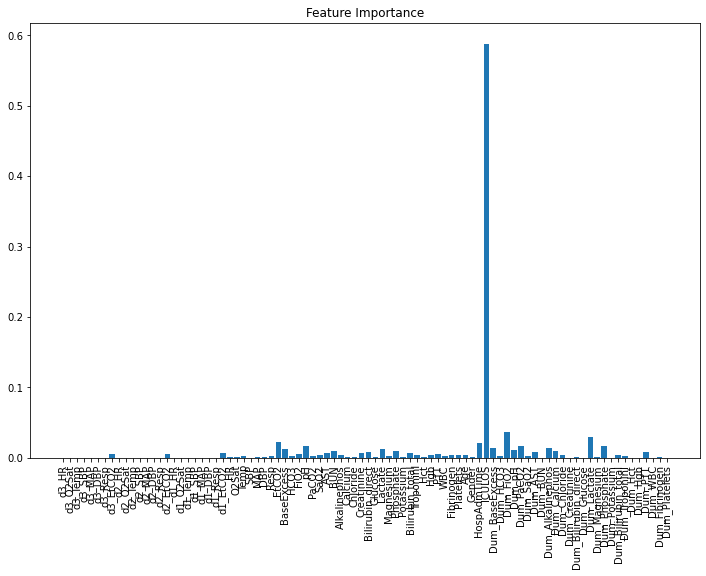

In [31]:
#Plot Feature Importance 
Plot_Feat_Imp(GB,Var_names,pd,np,plt,(12,8))

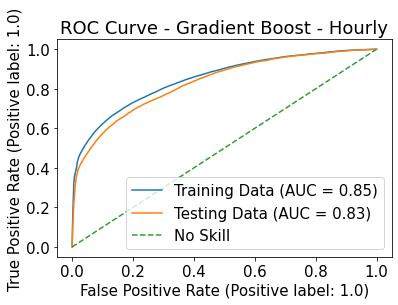

In [719]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB,X_train,y_train_all,ax=_,name='Training Data')
plot_roc_curve(GB,X_test,y_test_all,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Hourly')
plt.show()

Best Train Threshold=0.204682, F-Score=0.548
Best Test Threshold=0.195921, F-Score=0.497
Train AUC: 0.567 Test AUC: 0.492


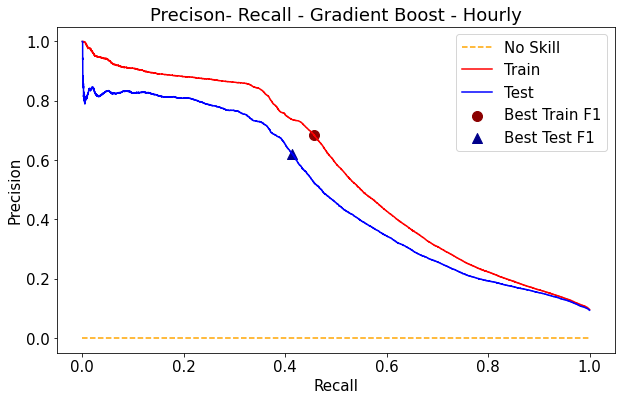

In [714]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Hourly'
prob=Plot_PR(GB,X_train,y_train_all,X_test,y_test_all,title,auc,precision_recall_curve,np,plt,(10,6))

In [161]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Hourly Data
q=GB.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.204682 else 0 for i in q]
print(classification_report(y_test_all,y_pred_test_new))
print(confusion_matrix(y_test_all,y_pred_test_new))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96    420053
         1.0       0.64      0.40      0.50     43136

    accuracy                           0.92    463189
   macro avg       0.79      0.69      0.73    463189
weighted avg       0.91      0.92      0.92    463189

[[410341   9712]
 [ 25710  17426]]


In [181]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(GB,0.204682,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11231
           1       0.36      0.35      0.35       870

    accuracy                           0.91     12101
   macro avg       0.65      0.65      0.65     12101
weighted avg       0.91      0.91      0.91     12101

[[10692   539]
 [  567   303]]


In [115]:
#CV Testing Results - Assess Hyperparameter performance across CV folds
#Get f1 scores for each fold
a=search_GB_Sepsis.cv_results_['split0_test_score']
b=search_GB_Sepsis.cv_results_['split1_test_score']
c=search_GB_Sepsis.cv_results_['split2_test_score']
d=search_GB_Sepsis.cv_results_['split3_test_score']
e=np.concatenate((a,b,c,d))
f=search_GB_Sepsis.cv_results_['mean_test_score']
n=len(search_GB_Sepsis.cv_results_['params'])
#Get Parameters for each CV
n_estimators=[search_GB_Sepsis.cv_results_['params'][i]['n_estimators'] for i in range(n)]
learning_rate=[search_GB_Sepsis.cv_results_['params'][i]['learning_rate'] for i in range(n)]
max_depth=[search_GB_Sepsis.cv_results_['params'][i]['max_depth'] for i in range(n)]
#Tabulate results
print('The  f1 test scores from cross validation had a mean value of {} and a standard deviation of {}.'.format(round(np.mean(e),4),round(np.std(e),4)))
col_names={0:'Split_0',1:'Split_1',2:'Split_2',3:'Split_3',4:'n_estimators',5:'learning_rate',6:'max_depth',7:'MeanScore'}
pd.DataFrame([a,b,c,d,n_estimators,learning_rate,max_depth,f]).T.rename(columns=col_names).sort_values('MeanScore',ascending=False)

The  f1 test scores from cross validation had a mean value of 0.0149 and a standard deviation of 0.0676.


,Split_0,Split_1,Split_2,Split_3,n_estimators,learning_rate,max_depth,MeanScore
5,0.416370,0.492576,0.230090,0.143428,200.0,0.010000,5.0,0.320616
2,0.165692,0.225765,0.062053,0.053790,200.0,0.010000,3.0,0.126825
4,0.000000,0.000000,0.000306,0.000000,100.0,0.010000,5.0,0.000076
0,0.000000,0.000000,0.000000,0.000000,50.0,0.010000,3.0,0.000000
17,0.000000,0.000000,0.000000,0.000000,200.0,0.000100,5.0,0.000000
28,0.000000,0.000000,0.000000,0.000000,100.0,0.000001,5.0,0.000000
27,0.000000,0.000000,0.000000,0.000000,50.0,0.000001,5.0,0.000000
26,0.000000,0.000000,0.000000,0.000000,200.0,0.000001,3.0,0.000000
25,0.000000,0.000000,0.000000,0.000000,100.0,0.000001,3.0,0.000000
24,0.000000,0.000000,0.000000,0.000000,50.0,0.000001,3.0,0.000000


### 5.4.2. Second Hyperparameter Search <a class="anchor" id="5.4.2.SecondHyperparameterSearch"></a>

In [81]:
#Randomized search for Gradient Boost Classifier, Sepsis Label
start = datetime.now()
GB2 = GradientBoostingClassifier(random_state=42,max_features='sqrt')
max_depth = [5,6,7]
n_estimators=[200,250,300]
learning_rate=[0.01]
distributions = {'max_depth': max_depth,'learning_rate': learning_rate, 'n_estimators': n_estimators}
GB_RS2=GridSearchCV(GB2,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_GB_Sepsis2=GB_RS2.fit(X_train,y_train_all)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_GB_Sepsis2.best_params_
search_GB_Sepsis2.best_params_

This process took 01 Hours 48 Minutes 19 Seconds 


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

In [116]:
#CV Testing Results - Assess Hyperparameter performance across CV folds
#Get f1 scores for each fold
a=search_GB_Sepsis2.cv_results_['split0_test_score']
b=search_GB_Sepsis2.cv_results_['split1_test_score']
c=search_GB_Sepsis2.cv_results_['split2_test_score']
d=search_GB_Sepsis2.cv_results_['split3_test_score']
e=np.concatenate((a,b,c,d))
f=search_GB_Sepsis2.cv_results_['mean_test_score']
#Get Parameters for each CV
n=len(search_GB_Sepsis2.cv_results_['params'])
n_estimators=[search_GB_Sepsis2.cv_results_['params'][i]['n_estimators'] for i in range(n)]
learning_rate=[search_GB_Sepsis2.cv_results_['params'][i]['learning_rate'] for i in range(n)]
max_depth=[search_GB_Sepsis2.cv_results_['params'][i]['max_depth'] for i in range(n)]
#Tabulate Results
print('The  f1 test scores from cross validation had a mean value of {} and a standard deviation of {}.'.format(round(np.mean(e),4),round(np.std(e),4)))
col_names={0:'Split_0',1:'Split_1',2:'Split_2',3:'Split_3',4:'n_estimators',5:'learning_rate',6:'max_depth',7:'MeanScore'}
pd.DataFrame([a,b,c,d,n_estimators,learning_rate,max_depth,f]).T.rename(columns=col_names).sort_values('MeanScore',ascending=False)

The  f1 test scores from cross validation had a mean value of 0.3853 and a standard deviation of 0.1251.


,Split_0,Split_1,Split_2,Split_3,n_estimators,learning_rate,max_depth,MeanScore
2,0.508195,0.520263,0.370043,0.302482,300.0,0.01,5.0,0.425246
8,0.515607,0.528374,0.359646,0.283660,300.0,0.01,7.0,0.421822
5,0.512885,0.524615,0.350204,0.284572,300.0,0.01,6.0,0.418069
7,0.506378,0.522217,0.325678,0.253607,250.0,0.01,7.0,0.401970
1,0.481645,0.513221,0.331446,0.255617,250.0,0.01,5.0,0.395482
4,0.501222,0.518433,0.300000,0.243239,250.0,0.01,6.0,0.390724
6,0.478051,0.506069,0.242424,0.205369,200.0,0.01,7.0,0.357978
3,0.468108,0.500000,0.196197,0.179976,200.0,0.01,6.0,0.336070
0,0.416370,0.492576,0.230090,0.143428,200.0,0.01,5.0,0.320616


In [82]:
#Create Model
start = datetime.now()
GB_2=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
GB_2.fit(X_train,y_train_all)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 07 Minutes 05 Seconds 


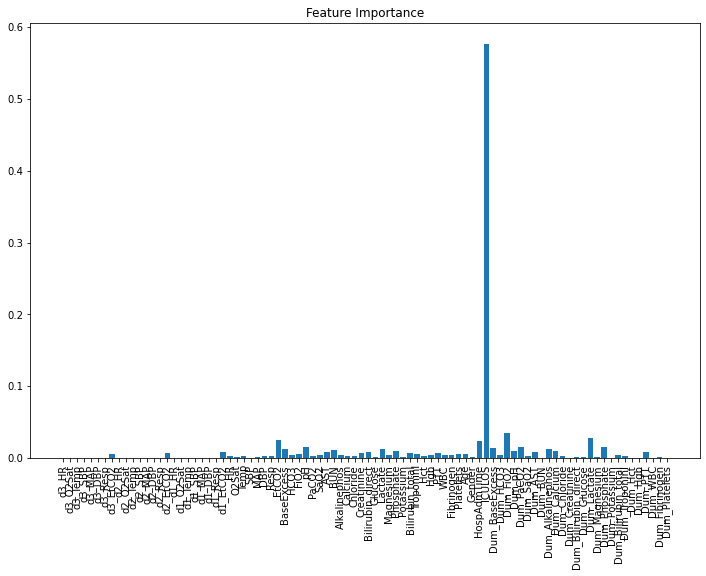

In [83]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_2,Var_names,pd,np,plt,(12,8))

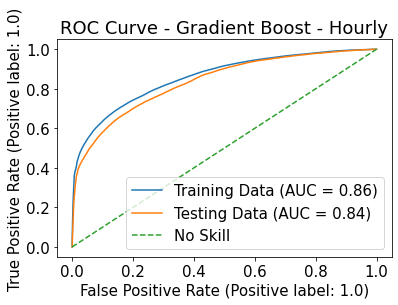

In [643]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_2,X_train,y_train_all,ax=_,name='Training Data')
plot_roc_curve(GB_2,X_test,y_test_all,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Hourly')
plt.show()

In [632]:
from PlotPrecisionRecall_ import Plot_PR

Best Train Threshold=0.204520, F-Score=0.555
Best Test Threshold=0.216028, F-Score=0.500
Train AUC: 0.581 Test AUC: 0.496


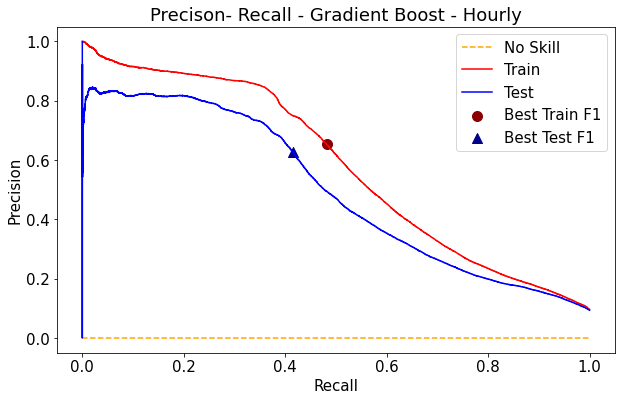

In [673]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Hourly'
prob=Plot_PR(GB_2,X_train,y_train_all,X_test,y_test_all,title,auc,precision_recall_curve,np,plt,(10,6))

In [757]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Hourly Data
q=GB_2.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.216 else 0 for i in q]
print(classification_report(y_test_all,y_pred_test_new))
print(confusion_matrix(y_test_all,y_pred_test_new))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96    420053
         1.0       0.63      0.42      0.50     43136

    accuracy                           0.92    463189
   macro avg       0.78      0.70      0.73    463189
weighted avg       0.91      0.92      0.92    463189

[[409363  10690]
 [ 25214  17922]]


In [617]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(GB_2,0.22,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11231
           1       0.35      0.36      0.35       870

    accuracy                           0.91     12101
   macro avg       0.65      0.65      0.65     12101
weighted avg       0.91      0.91      0.91     12101

[[10638   593]
 [  555   315]]


In [ ]:
#Calculate True Negatives and True Positives at probabilities ranging from 0 to 98, increments of 2 - Test
tn=[]
tp=[]
prob=[prob/100 for prob in range(0,100,2)]
for prob in prob:
    df_pred, cm, cr=PatientLevelClassification(GB_2,prob,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
    tn.append(cm[0,0])
    tp.append(cm[1,1])
    
#Calculate TP% and FP%
p=pd.DataFrame(df[df.id.isin(test_id)][['id', 'SepsisOnset']].reset_index(drop=True).groupby('id').SepsisOnset.sum())
actually_false=p.value_counts()[0]
actually_true=p.value_counts()[1]
tp_pct=np.round_((np.array(tp)/actually_true)*100,2)
fp_pct=np.round_((np.array(fp)/actually_false)*100,2)

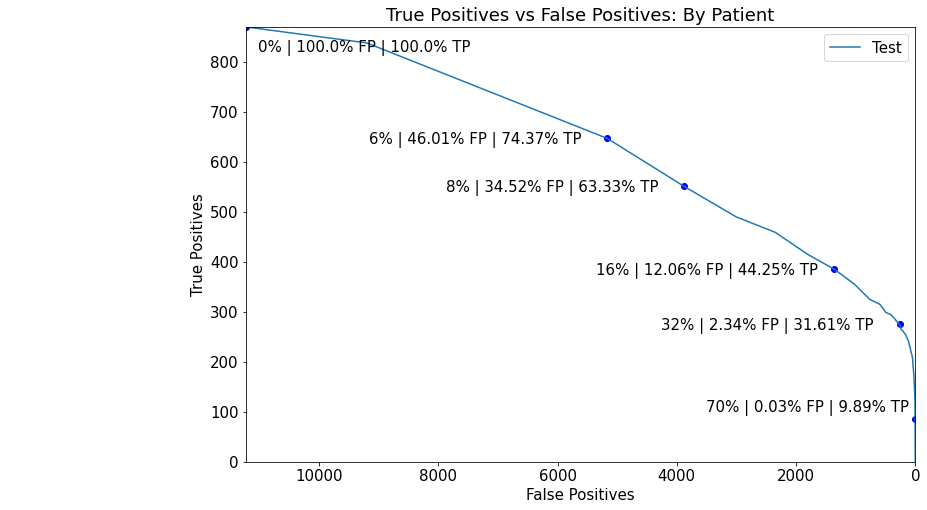

In [814]:
#Plot True Positives vs False Positives
fp=list(actually_false-np.array(tn))
plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
plt.plot(fp,tp,label='Test')
plt.axis((actually_false,0,0,actually_true))
prob=[str(prob)+'%' for prob in range(0,100,2)]
k=0
for s, x, y, w, z in zip(prob, fp, tp, fp_pct, tp_pct):
    if (k%4==0 or k==3) and (k<12 or k==16):
        plt.annotate(s+' | '+str(w)+'% FP | '+str(z)+'% TP', (x+4000, y-10))
        plt.scatter(x,y,c='blue')
    k=k+1
plt.annotate(prob[0]+' | '+str(fp_pct[0])+'% FP | '+str(tp_pct[0])+'% TP', (fp[0]-200, tp[0]-50))
plt.annotate(prob[-15]+' | '+str(fp_pct[-15])+'% FP | '+str(tp_pct[-15])+'% TP', (fp[-15]+3500, tp[-15]+15))
plt.scatter(fp[-15],tp[-15],c='blue')
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.legend()
plt.title('True Positives vs False Positives: By Patient')
plt.show()

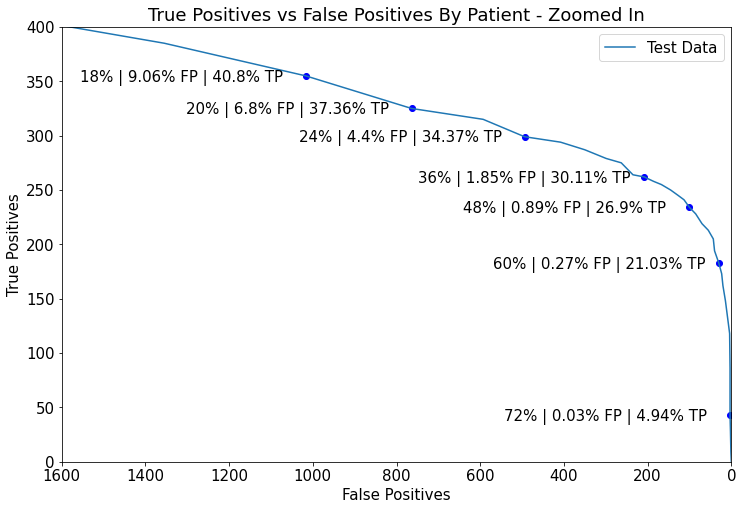

In [588]:
#Plot True Positives vs False Positives - Zoomed in
fp=list(actually_false-np.array(tn))
plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
plt.plot(fp,tp,label='Test')
plt.axis((1600,0,0,400))
prob=[str(prob)+'%' for prob in range(0,100,2)]
k=0
for s, x, y, w, z in zip(prob, fp, tp, fp_pct, tp_pct):
    if (k%6==0 or k==10 or k==9) and (40>k>6):
        plt.annotate(s+' | '+str(w)+'% FP | '+str(z)+'% TP', (x+540, y-5))
        plt.scatter(x,y,c='blue')
    k=k+1
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.legend()
plt.title('True Positives vs False Positives By Patient - Zoomed In')
plt.show()

In [ ]:
#Calculate Precision & Recall - Test
precision=np.array(tp)/(np.array(tp)+np.array(fp))
precision=np.nan_to_num(precision,nan=1)
recall=np.array(tp)/actually_true

In [ ]:
#Calculate True Negatives and True Positives at probabilities ranging from 0 to 98, increments of 2 - Training Data
tn_=[]
tp_=[]
prob=[prob/100 for prob in range(0,100,2)]
for prob in prob:
    df_pred, cm, cr=PatientLevelClassification(GB_2,prob,X_train,y_train_all,df,train_id,pd,classification_report,confusion_matrix)
    tn_.append(cm[0,0])
    tp_.append(cm[1,1])
    
#Calculate TP% and FP%
p=pd.DataFrame(df[df.id.isin(train_id)][['id', 'SepsisOnset']].reset_index(drop=True).groupby('id').SepsisOnset.sum())
actually_false=p.value_counts()[0]
actually_true=p.value_counts()[1]
tp_pct_=np.round_((np.array(tp_)/actually_true)*100,2)
fp_pct_=np.round_((np.array(fp_)/actually_false)*100,2)

In [657]:
#Calculate Precision & Recall - Train
fp_=list(actually_false-np.array(tn_))
precision_=np.array(tp_)/(np.array(tp_)+np.array(fp_))
precision_=np.nan_to_num(precision,nan=1)
recall_=np.array(tp_)/actually_true

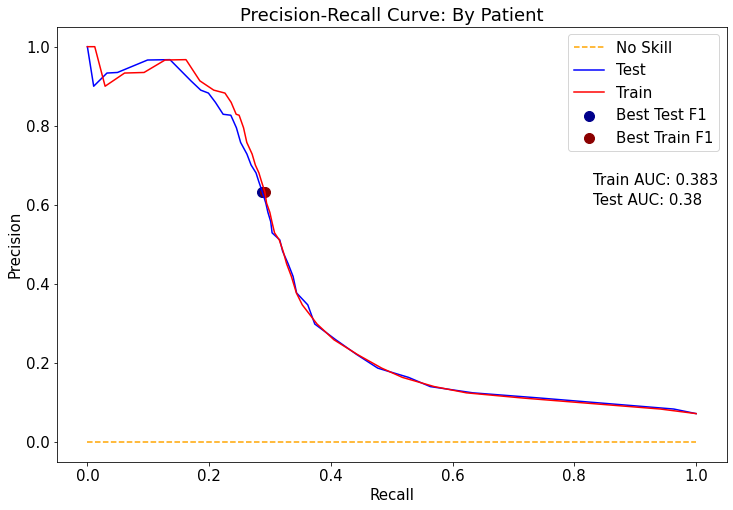

In [699]:
# Plot no skill line
plt.subplots(figsize=(12,8))
plt.plot([0, 1], [0, 0], linestyle='--', label='No Skill', c='orange')

#Plot Precision & Recall - Test
plt.rcParams.update({'font.size': 15})
plt.plot(recall,precision,label='Test',c='blue')

#Plot best probability according to f1
fscore = (2 * precision * recall) / (precision + recall)
fscore = np.nan_to_num(fscore)
ix = np.argmax(fscore)
plt.scatter(recall[ix], precision[ix], marker='o', color='darkblue', label='Best Test F1', s=100)

#Plot Precision & Recall - Train
plt.rcParams.update({'font.size': 15})
plt.plot(recall_,precision_,label='Train',c='red')

#Plot best probability according to f1
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
fscore_ = np.nan_to_num(fscore_)
ix_ = np.argmax(fscore_)
plt.scatter(recall_[ix_], precision_[ix_], marker='o', color='darkred', label='Best Train F1', s=100)

#Final plot details
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: By Patient')
plt.legend()
AUC_train=round(auc(recall_, precision_),3)
plt.annotate('Train AUC: '+str(AUC_train),(0.83,0.65))
AUC_test=round(auc(recall, precision),3)
plt.annotate('Test AUC: '+str(AUC_test),(0.83,0.6))
prob=[str(prob)+'%' for prob in range(0,100,2)]
k=0
plt.show()

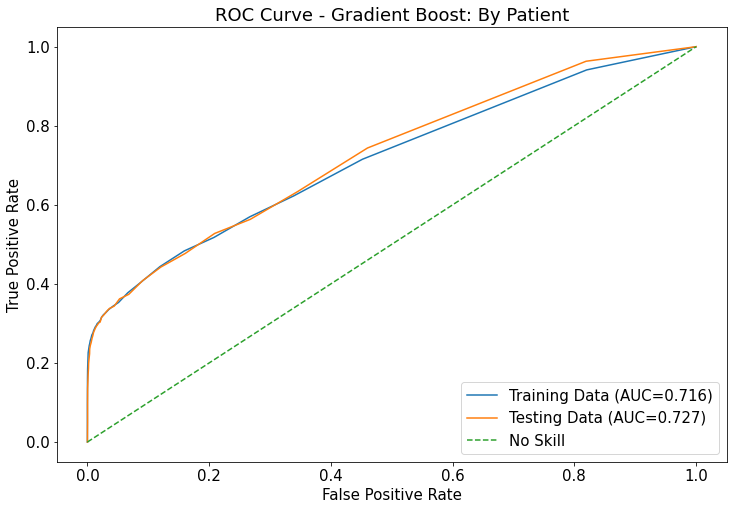

In [702]:
plt.subplots(figsize=(12,8))
ROC_test_AUC=round(auc(fp_pct/100,tp_pct/100),3)
ROC_train_AUC=round(auc(fp_pct_/100,tp_pct_/100),3)
plt.plot(fp_pct_/100,tp_pct_/100,label='Training Data (AUC={})'.format(ROC_train_AUC))
plt.plot(fp_pct/100,tp_pct/100,label='Testing Data (AUC={})'.format(ROC_test_AUC))
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boost: By Patient')
plt.show()

In [616]:
#Tabulate FPR, TPR, Thresholds & F1 Score
df_results=pd.DataFrame([tp,fp,tp_pct,fp_pct,prob,fscore]).T
df_results.rename(columns={0:'True Positives',1:'False Positives',2:'True Positive Rate',3:'False Positive Rate',4:'Threshold',5:'f1score'},inplace=True)
df_results

,True Positives,False Positives,True Positive Rate,False Positive Rate,Threshold,f1score
0,870,11231,100.0,100.0,0%,0.134145
1,870,11231,100.0,100.0,2%,0.134145
2,838,9201,96.32,81.93,4%,0.153635
3,647,5167,74.37,46.01,6%,0.193597
4,551,3877,63.33,34.52,8%,0.208003
5,490,3004,56.32,26.75,10%,0.224565
6,459,2348,52.76,20.91,12%,0.24966
7,415,1805,47.7,16.07,14%,0.268608
8,385,1355,44.25,12.06,16%,0.295019
9,355,1017,40.8,9.06,18%,0.316682


In [745]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(GB_2,0.04,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.18      0.31     11231
           1       0.08      0.96      0.15       870

    accuracy                           0.24     12101
   macro avg       0.53      0.57      0.23     12101
weighted avg       0.92      0.24      0.29     12101

[[2030 9201]
 [  32  838]]


In [747]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(GB_2,0.34,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     11231
           1       0.53      0.30      0.39       870

    accuracy                           0.93     12101
   macro avg       0.74      0.64      0.67     12101
weighted avg       0.92      0.93      0.92     12101

[[10996   235]
 [  606   264]]


In [749]:
#Return classification report & confusion matrix of testing data with optimal train probability threshold
#Patient Level Data
df_pred, cm, cr=PatientLevelClassification(GB_2,0.11,X_test,y_test_all,df,test_id,pd,classification_report,confusion_matrix)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.76      0.85     11231
           1       0.15      0.54      0.23       870

    accuracy                           0.74     12101
   macro avg       0.55      0.65      0.54     12101
weighted avg       0.90      0.74      0.80     12101

[[8534 2697]
 [ 399  471]]


In [755]:
#Save the model
#os.chdir("../../models")
#filename = 'finalized_sepsis_model.sav'
#joblib.dump(model, filename)

['finalized_sepsis_model.sav']